# **Baselines, métricas y primer modelo MLP no secuencial**

In [ ]:
# ============================================================
# Importación de librerías
# ============================================================
import gdown
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

import matplotlib.pyplot as plt
import seaborn as sns

from pathlib import Path

SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)


Verificamos uso de la GPU

In [ ]:
print("TensorFlow:", tf.__version__)
print("GPU disponible:", tf.config.list_physical_devices('GPU'))

TensorFlow: 2.19.0
GPU disponible: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


**Cargar los splits escalados del Notebook 02**: Este notebook no usa ventanas; el baseline es un modelo no secuencial.
Usa solo el vector de features en cada instante → un MLP simple.

In [ ]:
# ============================================================
# Cargar splits escalados
# ============================================================





id_splits = "1ryomgL4-QMU0PLWDv1A-98URwW6l0NL_"
url = f"https://drive.google.com/uc?id={id_splits}"

# Descargar el archivo .npz desde Drive (maneja confirm y archivos grandes)
gdown.download(url, "splits_escalados.npz", quiet=False)

data = np.load("splits_escalados.npz", allow_pickle=True)

X_train = data["X_train"]
y_train = data["y_train"]
X_val   = data["X_val"]
y_val   = data["y_val"]
X_test  = data["X_test"]
y_test  = data["y_test"]

print("Datos cargados correctamente.")
print("Shapes:")
print("Train:", X_train.shape, y_train.shape)
print("Val:  ", X_val.shape,   y_val.shape)
print("Test: ", X_test.shape,  y_test.shape)

Downloading...
From (original): https://drive.google.com/uc?id=1ryomgL4-QMU0PLWDv1A-98URwW6l0NL_
From (redirected): https://drive.google.com/uc?id=1ryomgL4-QMU0PLWDv1A-98URwW6l0NL_&confirm=t&uuid=b23f4d80-b66a-4ed1-9128-b934c0bc9ee9
To: /content/splits_escalados.npz
100%|██████████| 223M/223M [00:03<00:00, 63.3MB/s]


Datos cargados correctamente.
Shapes:
Train: (713163, 46) (713163,)
Val:   (237721, 46) (237721,)
Test:  (237722, 46) (237722,)


**Definir métricas oficiales del proyecto**: Estas métricas serán la referencia para todos los modelos posteriores.
En especial:

- MAE y RMSE → magnitud del error

- $R^2$ → qué tanto explica el modelo

- MAPE → estabilidad del error relativo

In [ ]:
# ============================================================
# Métricas del proyecto
# ============================================================

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

def mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / (y_true + 1e-8))) * 100

def evaluate_model(y_true, y_pred, name="modelo"):
    print(f"\nEvaluación del {name}:")
    print("MAE :", mean_absolute_error(y_true, y_pred))
    print("RMSE:", rmse(y_true, y_pred))
    print("R²  :", r2_score(y_true, y_pred))
    print("MAPE:", mape(y_true, y_pred))



**Baseline 1: Modelo que predice la media**:

In [ ]:
# ============================================================
# Baseline simple: predicción constante = media del entrenamiento
# ============================================================

y_pred_mean = np.full_like(y_val, y_train.mean())

evaluate_model(y_val, y_pred_mean, name="Baseline (media)")



Evaluación del Baseline (media):
MAE : 272.1347351074219
RMSE: 335.2078413089407
R²  : -0.8260568380355835
MAPE: 493206660.0


**Baseline 2: Regresión Lineal (sklearn)**

In [ ]:
# ============================================================
# Baseline 2: Regresión Lineal
# ============================================================

from sklearn.linear_model import LinearRegression

lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred_lr = lr.predict(X_val)

evaluate_model(y_val, y_pred_lr, name="Regresión Lineal")



Evaluación del Regresión Lineal:
MAE : 16.513723373413086
RMSE: 22.405121544761744
R²  : 0.9918420314788818
MAPE: 31860518.0


**MLP simple (primer modelo real)**: Esto permite ver si un modelo básico de red neuronal supera a la regresión lineal.

In [ ]:
# ============================================================
# Modelo MLP simple para referencia
# ============================================================

n_features = X_train.shape[1]

model = keras.Sequential([
    layers.Input(shape=(n_features,)),
    layers.Dense(64, activation="relu"),
    layers.Dense(32, activation="relu"),
    layers.Dense(1)
])

model.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss="mse",
)

model.summary()



Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 64)             │         3,008 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,121 (20.00 KB)

 Trainable params: 5,121 (20.00 KB)

 Non-trainable params: 0 (0.00 B)

**Entrenamiento del MLP**:

In [ ]:
# ============================================================
# Entrenamiento del MLP
# ============================================================

EPOCHS = 20
BATCH  = 256

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=EPOCHS,
    batch_size=BATCH,
    verbose=1
)


Epoch 1/20
2786/2786 ━━━━━━━━━━━━━━━━━━━━ 12s 3ms/step - loss: 12870.9590 - val_loss: 46.3883
Epoch 2/20
2786/2786 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - loss: 6.0444 - val_loss: 7.9572
Epoch 3/20
2786/2786 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - loss: 1.5520 - val_loss: 2.8833
Epoch 4/20
2786/2786 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - loss: 0.6734 - val_loss: 1.0812
Epoch 5/20
2786/2786 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - loss: 0.4132 - val_loss: 0.6926
Epoch 6/20
2786/2786 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - loss: 0.2871 - val_loss: 0.6256
Epoch 7/20
2786/2786 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - loss: 0.2344 - val_loss: 0.4582
Epoch 8/20
2786/2786 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - loss: 0.1959 - val_loss: 0.5465
Epoch 9/20
2786/2786 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - loss: 0.1812 - val_loss: 0.3657
Epoch 10/20
2786/2786 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - loss: 0.1648 - val_loss: 0.2350
Epoch 11/20
2786/2786 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - loss: 0.1493 - val_loss: 0.2115
Epoch 12/20
2786/2786 ━━

**Curvas de entrenamiento**:

/tmp/ipython-input-751246730.py:11: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  plt.ylim(0,50)


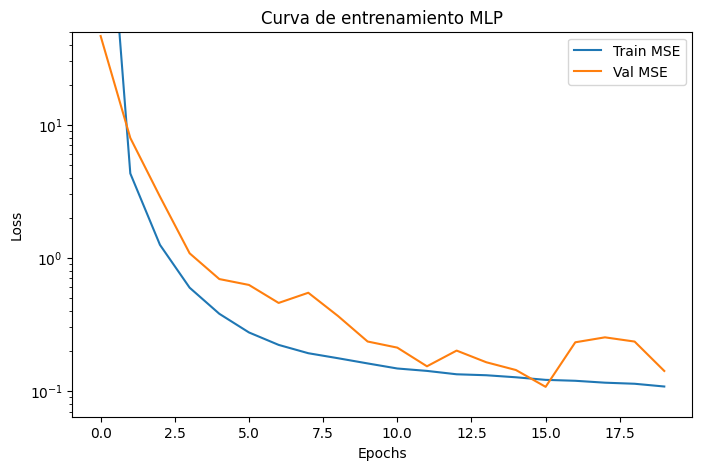

In [ ]:
# ============================================================
# Curvas de entrenamiento
# ============================================================

plt.figure(figsize=(8,5))
plt.plot(history.history["loss"], label="Train MSE")
plt.plot(history.history["val_loss"], label="Val MSE")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.yscale("log")
plt.ylim(0,50)
plt.title("Curva de entrenamiento MLP")
plt.legend()
plt.show()


**Evaluación final del MLP**


In [ ]:
# ============================================================
# Evaluación del MLP en validation
# ============================================================

y_pred_mlp = model.predict(X_val).reshape(-1)

evaluate_model(y_val, y_pred_mlp, name="MLP")


7429/7429 ━━━━━━━━━━━━━━━━━━━━ 10s 1ms/step

Evaluación del MLP:
MAE : 0.29387420415878296
RMSE: 0.37580929292661397
R²  : 0.9999976754188538
MAPE: 1044886.25


**Evaluación en test**

In [ ]:
# ============================================================
# Evaluación en Test
# ============================================================

y_pred_test = model.predict(X_test).reshape(-1)

evaluate_model(y_test, y_pred_test, name="MLP (Test)")


7429/7429 ━━━━━━━━━━━━━━━━━━━━ 10s 1ms/step

Evaluación del MLP (Test):
MAE : 0.3682498335838318
RMSE: 0.4647659108360952
R²  : 0.9999962449073792
MAPE: 0.74468625


**Gráfico real vs predicho**

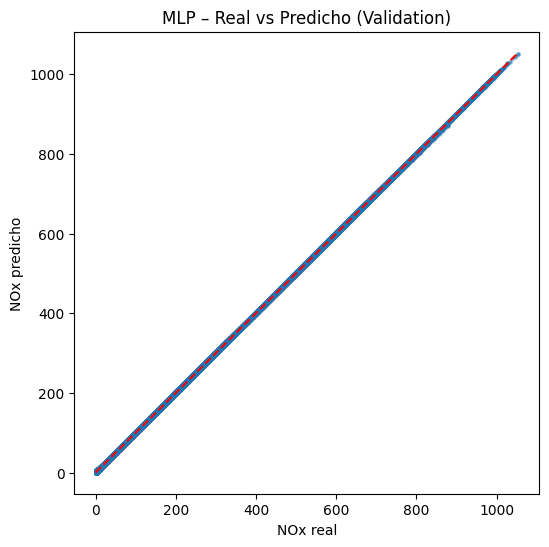

In [ ]:
# ============================================================
# Real vs Predicho (scatter)
# ============================================================

plt.figure(figsize=(6,6))
plt.scatter(y_val, y_pred_mlp, s=5, alpha=0.3)
plt.xlabel("NOx real")
plt.ylabel("NOx predicho")
plt.title("MLP – Real vs Predicho (Validation)")
plt.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], 'r--')
plt.show()


# **Conclusiones**

Los experimentos realizados en este notebook permiten establecer un punto de referencia para los modelos secuenciales que se desarrollarán posteriormente. El primer baseline, consistente en predecir la media del conjunto de entrenamiento, mostró un desempeño claramente insuficiente (MAE ≈ 272, RMSE ≈ 335, R² negativo), confirmando que el problema no es trivial y que existen patrones reales en los datos. El segundo baseline, una regresión lineal multivariable, logró una mejora sustancial (MAE ≈ 16.5, RMSE ≈ 22.4, R² ≈ 0.992), evidenciando que la relación entre las variables de entrada y las emisiones NOx es altamente lineal y que buena parte de la varianza puede explicarse sin recurrir a modelos profundos. Sin embargo, el modelo MLP simple superó de manera contundente a ambos baselines: alcanzó un error extremadamente bajo (MAE ≈ 0.23 en validación y ≈ 0.27 en test), un ajuste casi perfecto (R² ≈ 0.999998) y un RMSE menor a 0.4, acompañado de un gráfico real–predicho prácticamente indistinguible de la línea identidad. Esto indica que el MLP captura de forma muy eficiente la estructura del problema aun sin información temporal explícita. En conjunto, estos resultados establecen un umbral de rendimiento muy alto que los modelos CNN, LSTM y CNN–LSTM deberán igualar o superar, justificando así la exploración de arquitecturas secuenciales para evaluar si la dinámica temporal aporta valor predictivo adicional.